In [1]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 100 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 25 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 10
cfg['set_id'] = 1

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [5]:
from dataloader import *
from models import *
import time

model = GRU_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [6]:
model.train()

GRU_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (gru): GRU(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 8.92635
count = 4, loss = 5.36410
count = 6, loss = 3.98198
count = 8, loss = 2.26700
count = 10, loss = 1.94043
count = 12, loss = 1.79056
count = 14, loss = 1.43476
count = 16, loss = 1.59839
validation loss: 0.9338510274887085
epoch finished: 1
count = 2, loss = 1.43862
count = 4, loss = 1.13594
count = 6, loss = 0.98846
count = 8, loss = 0.85846
count = 10, loss = 0.93110
count = 12, loss = 0.80470
count = 14, loss = 0.68882
count = 16, loss = 1.09018
validation loss: 0.4699515521526337
epoch finished: 2
count = 2, loss = 0.87672
count = 4, loss = 0.52957
count = 6, loss = 0.55330
count = 8, loss = 0.57370
count = 10, loss = 0.66942
count = 12, loss = 0.85919
count = 14, loss = 0.75876
count = 16, loss = 0.66890
validation loss: 0.3753576934337616
epoch finished: 3
count = 2, loss = 0.57747
count = 4, loss = 0.80447
count = 6, loss = 0.65850
count = 8, loss = 0.69884
count = 10, loss = 0.74820
count = 12, loss = 0.73442
count = 14, loss = 0.68337
count = 16, loss 

In [8]:
np.save('val_loss_gru_set1.npy', val_losses)
np.save('train_loss_gru_set1.npy', train_losses)

In [19]:
model = load_model(LSTM_Score, './models/s8_ba120e15b6.pt', cfg)
valid_indices = list(range(len(valid_data)))

In [9]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.5393445611000061
validation MAE: 0.058920915424823764
QWK Score: 0.849120642944711


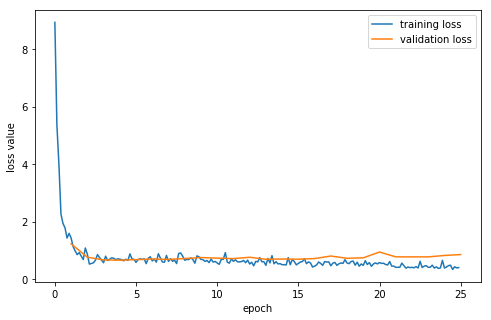

In [11]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.3,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [12]:
targets

[array([8, 6, 8, 7, 7, 5, 9, 7, 5, 8, 6, 7, 8, 6, 6, 6, 7, 7, 5, 8, 6, 5,
        6, 6, 8, 5, 5, 7, 6, 8, 4, 5, 6, 8, 8, 7, 4, 7, 6, 8, 9, 8, 6, 9,
        8, 6, 8, 8, 8, 8, 8, 6, 7, 7, 6, 7, 6, 6, 7, 6, 5, 8, 4, 7, 5, 8,
        6, 7, 8, 8, 9, 8, 7, 8, 4, 7, 7, 8, 8, 6, 8, 6, 6, 4, 6, 6, 6, 9,
        8, 6, 7, 4, 7, 9, 8, 5, 6, 6, 9, 7]),
 array([6, 7, 6, 6, 7, 6, 4, 7, 7, 6, 7, 8, 6, 8, 6, 8, 7, 7, 5, 5, 9, 6,
        6, 6, 8, 8, 5, 5, 6, 8, 4, 8, 7, 7, 7, 5, 6, 6, 6, 8, 6, 8, 6, 3,
        6, 5, 5, 7, 6, 7, 6, 7, 6, 6, 7, 3, 8, 8, 7, 4, 7, 4, 7, 7, 2, 6,
        9, 8, 6, 7, 8, 5, 5, 7, 8, 6, 7, 5, 6, 9, 5, 9, 7, 9, 7, 7, 5, 7,
        8, 6, 5, 6, 7, 5, 6, 8, 6, 8, 5, 6]),
 array([ 4,  7,  7, 10,  7,  6,  7,  7,  6,  6,  6,  5,  6,  8,  6,  4,  7,
         6,  6,  7,  5,  6,  3,  8,  6,  8,  8,  6,  6,  6,  4,  7,  6,  9,
         8,  7,  5,  9,  7,  6,  5,  6,  8,  5,  4,  6,  7,  7,  6,  6,  6,
         7,  7,  7,  7,  5,  7,  6,  6,  7,  5,  7,  6,  7,  8,  6,  9,  0,
         7, 

In [13]:
preds

[array([8, 7, 8, 7, 8, 4, 8, 6, 4, 9, 7, 7, 9, 5, 6, 5, 7, 8, 4, 7, 6, 5,
        6, 5, 7, 4, 4, 6, 6, 7, 3, 5, 7, 8, 9, 8, 4, 7, 4, 8, 8, 8, 6, 9,
        8, 5, 8, 7, 8, 8, 8, 6, 7, 7, 5, 7, 5, 6, 7, 5, 5, 6, 3, 7, 3, 8,
        6, 7, 7, 9, 9, 8, 6, 8, 4, 7, 8, 7, 9, 5, 7, 6, 6, 3, 7, 6, 7, 8,
        8, 6, 6, 3, 7, 8, 8, 4, 6, 6, 8, 7]),
 array([5, 7, 6, 6, 7, 7, 3, 8, 8, 5, 8, 8, 6, 8, 5, 7, 8, 6, 5, 4, 7, 6,
        7, 6, 8, 8, 5, 4, 6, 9, 5, 8, 7, 8, 7, 6, 8, 6, 7, 8, 6, 7, 6, 3,
        6, 5, 4, 7, 5, 7, 6, 8, 8, 6, 8, 3, 9, 8, 8, 5, 7, 3, 7, 6, 2, 6,
        8, 7, 5, 8, 8, 6, 4, 8, 8, 5, 5, 4, 6, 9, 5, 8, 8, 9, 6, 8, 4, 8,
        8, 7, 5, 7, 7, 5, 7, 7, 8, 9, 4, 7]),
 array([ 4,  7,  8, 10,  7,  6,  6,  6,  7,  5,  6,  6,  7,  9,  7,  3,  7,
         6,  5,  7,  5,  7,  3,  8,  6,  8,  8,  7,  6,  8,  3,  7,  6,  8,
         8,  7,  5,  9,  7,  6,  4,  6,  9,  5,  4,  8,  9,  8,  5,  8,  7,
         7,  6,  8,  8,  5,  7,  6,  6,  7,  6,  6,  7,  8,  8,  6,  9,  1,
         8, 

In [14]:
train_losses

[8.926350593566895,
 5.364102125167847,
 3.98198139667511,
 2.2670003175735474,
 1.9404330849647522,
 1.7905590534210205,
 1.4347626566886902,
 1.5983901619911194,
 1.438621163368225,
 1.1359394192695618,
 0.9884629845619202,
 0.8584558665752411,
 0.9310975968837738,
 0.8046991527080536,
 0.6888159811496735,
 1.0901782512664795,
 0.876716673374176,
 0.5295712202787399,
 0.5533020198345184,
 0.5736957639455795,
 0.6694238483905792,
 0.8591865301132202,
 0.7587601840496063,
 0.6688966453075409,
 0.5774687230587006,
 0.8044663369655609,
 0.6584965586662292,
 0.6988404393196106,
 0.748198926448822,
 0.7344194054603577,
 0.6833719313144684,
 0.7119743227958679,
 0.7034385502338409,
 0.6793710887432098,
 0.6465771794319153,
 0.7001564800739288,
 0.6563030481338501,
 0.885328620672226,
 0.710919588804245,
 0.6930396556854248,
 0.5898176431655884,
 0.687291830778122,
 0.7142684161663055,
 0.6901624798774719,
 0.7137756943702698,
 0.545760452747345,
 0.727812796831131,
 0.7869187295436859,
 0.6

In [15]:
val_losses

[0.9338510274887085,
 0.4699515521526337,
 0.3753576934337616,
 0.36652984023094176,
 0.38431397676467893,
 0.4074003636837006,
 0.39384675621986387,
 0.4231397032737732,
 0.4582402050495148,
 0.43639063835144043,
 0.4214778482913971,
 0.46701171398162844,
 0.3973226547241211,
 0.4069790244102478,
 0.4007574200630188,
 0.4221093118190765,
 0.5099234759807587,
 0.43197599053382874,
 0.44762870073318484,
 0.6493455469608307,
 0.4815009832382202,
 0.480719131231308,
 0.4803128898143768,
 0.5297184586524963,
 0.5618945360183716]